# Tutorial: fitting a FSRQ broad-band SED using angpy and Gammapy
In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `gammapy` wrapper.
The wrapper defines a custom [SpectralModel](https://docs.gammapy.org/0.20/api/gammapy.modeling.models.SpectralModel.html), representing the emission due to a combination of radiative processes. The `SpectralModel` can be used either to fit flux points or to perform a forward-folding likelihood fit (if the instrument response is available in a format compatible with `gammapy`). 

Several combination of radiative processes can be considered to model the broad-band emission of jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:

 * `SycnhrotronSelfComptonModel`, representing the sum of synchrotron and synchrotron self Compton (SSC) radiation. This scenario is commonly considered to model BL Lac sources;

 * `ExternalComptonModel`, representing the sum of synchrotron and synchrotron self Compton radiation along with an external Compton (EC) component. EC scattering can be computed considering a list of target photon fields. This scenario is commonly considered to model flat spectrum radio quasars (FSRQs).

In this tutorial we will show how to use `ExternalComptonSpectralModel` to perform the fit of the broad-band SED of PKS1510-089, measured during its gamma-ray flaring activity in 2015 [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract). We select the MWL SED corresponding to the period identified in the paper as "Period B" (MJD 57164-57166). 

[Gammapy](https://gammapy.org/) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import c, G, M_sun
import matplotlib.pyplot as plt
import pkg_resources

# import agnpy classes
from agnpy.spectra import LogParabola
from agnpy.fit import ExternalComptonModel, load_gammapy_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_y_label

load_mpl_rc()

# import gammapy classes
from gammapy.modeling.models import SkyModel
from gammapy.modeling import Fit

The `ExternalComptonModel` wraps the `agnpy` functions to compute synchrotron, SSC, and EC radiation. It returns a `gammapy.modeling.SpectralModel`. To initialise the model, the electron distribution and a list of targets for EC has to be specified, the remaining parameters (the ones of the emission region and of the line / thermal emitters) will be initialised automatically and can be modified at a later stage.

The `ExternalComptonModel` class provides both the `sherpa` and `gammapy` wrappers. You should specify, through the `backend` argument, which package you want to use.

In this case we choose to consider only EC on the DT radiation.

In [2]:
# electron energy distribution
n_e = LogParabola(
    k=1 * u.Unit("cm-3"), p=2.0, q=0.2, gamma_0=1e2, gamma_min=1, gamma_max=3e4
)

# initialise the sherpa model, consider only EC on the DT radiation
ec_model = ExternalComptonModel(n_e, ["dt"], ssa=True, backend="gammapy")

Let us set appropriate parameters for the emission region. The size of the blob, $R_{\rm b}$, is set by the variability timescale, $t_{\rm var}$, via

\begin{equation}
R_{\rm b} = \frac{c \delta_{\rm D} t_{\rm var}}{1 + z},
\end{equation}

where $c$ is the speed of light, $\delta_{\rm D}$ the Doppler factor, and $z$ the redshift.

The parameters of the accretion disk and the DT are taken from [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract).

In [3]:
z = 0.361

# - blob parameters
Gamma = 20
delta_D = 25
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))  # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta  # viewing angle
B = 0.35 * u.G
# size and location of the emission region
t_var = 0.5 * u.d
r = 6e17 * u.cm

# - disk parameters
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 3e4 * R_g

# - DT parameters
xi_dt = 0.6
T_dt = 2e3 * u.K
# Ghisellini and Tavecchio's Formula
# relating the DT radius to the disk luminosity (check the reference)
R_dt = 2.5 * 1e18 * np.sqrt(L_disk.to_value("erg s-1") / 1e45) * u.cm

In [4]:
# emission regions parameters
ec_model.parameters["z"].value = z
ec_model.parameters["delta_D"].value = delta_D
ec_model.parameters["log10_B"].value = np.log10(0.35)
ec_model.parameters["mu_s"].value = mu_s
ec_model.parameters["t_var"].value = t_var.to_value("s")
ec_model.parameters["t_var"].frozen = True
ec_model.parameters["log10_r"].value = np.log10(r.to_value("cm"))

# we freeze the reference energy of the log parabola
ec_model.parameters["log10_gamma_0"].frozen = True

# target parameters
# - disk
ec_model.parameters["log10_L_disk"].value = np.log10(L_disk.to_value("erg s-1"))
ec_model.parameters["M_BH"].value = M_BH.to_value("g")
ec_model.parameters["m_dot"].value = m_dot.to_value("g s-1")
ec_model.parameters["R_in"].value = R_in.to_value("cm")
ec_model.parameters["R_out"].value = R_out.to_value("cm")
# - DT
ec_model.parameters["xi_dt"].value = xi_dt
ec_model.parameters["T_dt"].value = T_dt.to_value("K")
ec_model.parameters["R_dt"].value = R_dt.to_value("cm")

We can display all the parameters of the model at once

In [5]:
ec_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str5,int64,float64,float64,bool,bool,str1
spectral,log10_k,0.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p,2.0000e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,q,2.0000e-01,,0.000e+00,1.000e-03,1.000e+00,False,False,
spectral,log10_gamma_0,2.0000e+00,,0.000e+00,2.000e+00,6.000e+00,True,False,
spectral,log10_gamma_min,0.0000e+00,,0.000e+00,0.000e+00,4.000e+00,True,False,
spectral,log10_gamma_max,4.4771e+00,,0.000e+00,4.000e+00,8.000e+00,True,False,
spectral,z,3.6100e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,2.5000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-4.5593e-01,,0.000e+00,-4.000e+00,2.000e+00,False,False,


or display separately the parameters related to the electrons energy distribution...

In [6]:
ec_model.spectral_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k,0.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p,2.0000e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,q,2.0000e-01,,0.000e+00,1.000e-03,1.000e+00,False,False,
spectral,log10_gamma_0,2.0000e+00,,0.000e+00,2.000e+00,6.000e+00,True,False,
spectral,log10_gamma_min,0.0000e+00,,0.000e+00,0.000e+00,4.000e+00,True,False,
spectral,log10_gamma_max,4.4771e+00,,0.000e+00,4.000e+00,8.000e+00,True,False,


and the parameters related to the emission region, the blob in this case

In [7]:
ec_model.emission_region_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str7,float64,str1,int64,float64,float64,bool,bool,str1
spectral,z,3.6100e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,2.5000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-4.5593e-01,,0.000e+00,-4.000e+00,2.000e+00,False,False,
spectral,t_var,4.3200e+04,s,0.000e+00,1.000e+01,3.142e+07,True,False,
spectral,mu_s,9.9925e-01,,0.000e+00,0.000e+00,1.000e+00,True,False,
spectral,log10_r,1.7778e+01,,0.000e+00,1.600e+01,2.200e+01,True,False,


in case of the `ExternalComptonSpectralModel`, we can display also the parameters of the targets (i.e. of the line and thermal emitters producing the photon targets for EC scattering. 

In [8]:
ec_model.targets_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str12,float64,str5,int64,float64,float64,bool,bool,str1
spectral,log10_L_disk,4.5826e+01,,0.000e+00,4.200e+01,4.800e+01,True,False,
spectral,M_BH,1.1354e+41,g,0.000e+00,1.000e+32,1.000e+45,True,False,
spectral,m_dot,8.9457e+25,g s-1,0.000e+00,1.000e+24,1.000e+30,True,False,
spectral,R_in,5.0589e+13,cm,0.000e+00,1.000e+12,1.000e+16,True,False,
spectral,R_out,2.5295e+17,cm,0.000e+00,1.000e+12,1.000e+19,True,False,
spectral,xi_dt,6.0000e-01,,0.000e+00,0.000e+00,1.000e+00,True,False,
spectral,T_dt,2.0000e+03,K,0.000e+00,1.000e+02,1.000e+04,True,False,
spectral,R_dt,6.4711e+18,cm,0.000e+00,1.000e+17,1.000e+20,True,False,


### Fit with `gammapy`
Here we start the procedure to fit with Gammapy.

#### 1) load the MWL flux points, add systematics
A function is provided in `agnpy.fit` to directly load flux points in a `gammapy.estimators.FluxPoints` object. It reads the data from a file, included in the package, containing a MWL SED following [these specifications](https://gamma-astro-data-formats.readthedocs.io/en/v0.2/spectra/flux_points/index.html).

The same function allows to add a systematic error on the flux points, this is done with a dictionary specifying the instrument name and the systematic error, expressed as a relative error on the flux. The systematic error is summed in quadrature to the statistical error.

In this example, we use a very rough and conservative estimate of the systematic errors ($30\%$ of the flux for VHE instruments, $10\%$ for HE and X-ray instruments, $5\%$ for all the other instruments).

Specifying the systematic errors through the dictionary is optional.

We can also set the minimum and maximum energy to be used in the fit. We exclude points below $10^{11}\,{\rm Hz}$, as they are measured in the radio band with large integration regions. They hence include the extended emission of the jet, while in our model we are considering the emission from a finite region of the jet, the blob.

In [9]:
systematics_dict = {
    "Fermi-LAT": 0.10,
    "KVA1": 0.05,
    "KVA2": 0.05,
    "MAGIC": 0.30,
    "Metsahovi": 0.05,
    "NICS1": 0.05,
    "NICS2": 0.05,
    "SMART1": 0.05,
    "Swift-XRT": 0.10,
    "TCS1": 0.05,
    "TCS2": 0.05,
    "TCS3": 0.05,
    "TCS4": 0.05,
    "TCS5": 0.05,
    "TCS6": 0.05,
    "UVOT": 0.05,
}

# min and max energy to be considered in the fit
E_min = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
E_max = 100 * u.TeV

datasets = load_gammapy_flux_points(
    "../../agnpy/data/mwl_seds/PKS1510-089_2015b.ecsv", E_min, E_max, systematics_dict
)

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

For the gammapy wrapper, we have to define a spectral model and associate it to the list of datasets we obtained from the flux points.

In [10]:
sky_model = SkyModel(spectral_model=ec_model, name="PKS1510-089")
datasets.models = [sky_model]

/Users/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/Users/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/Users/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow enc

Let us plot all the flux points and the initial model 

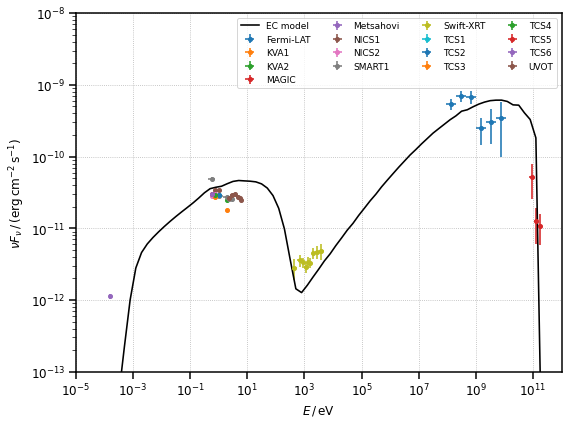

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

for dataset in datasets:
    dataset.data.plot(ax=ax, label=dataset.name)

ec_model.plot(
    ax=ax,
    energy_bounds=[1e-6, 1e14] * u.eV,
    energy_power=2,
    label="EC model",
    color="k",
    lw=1.6,
)

ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.set_xlim([1e-5, 1e12])
ax.set_ylim([1e-13, 1e-8])
ax.legend(ncol=4, fontsize=9)

plt.show()

#### 3) run the fit

In [12]:
%%time
# define the fitter
fitter = Fit()
results = fitter.run(datasets)

/Users/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:67: RuntimeWarning: overflow encountered in true_divide
  return np.where(tau < 1e-3, 1, 3 * u / tau)
/Users/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/Users/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/Users/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, 

CPU times: user 4min 48s, sys: 14.9 s, total: 5min 2s
Wall time: 5min 4s


In [13]:
print(results)
print(ec_model.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 317
	total stat : 220.71

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

  type         name         value     unit   error      min        max    frozen is_norm link
-------- --------------- ----------- ----- --------- ---------- --------- ------ ------- ----
spectral         log10_k  2.4521e-01       1.577e-01 -1.000e+01 1.000e+01  False   False     
spectral               p  2.1681e+00       1.243e-01  1.000e+00 5.000e+00  False   False     
spectral               q  3.3617e-01       3.368e-02  1.000e-03 1.000e+00  False   False     
spectral   log10_gamma_0  2.0000e+00       0.000e+00  2.000e+00 6.000e+00   True   False     
spectral log10_gamma_min  0.0000e+00       0.000e+00  0.000e+00 4.000e+00   True   False     
spectral log10_gamma_max  4.4771e+00       0.000e

Now let us plot the final model and the flux points

/Users/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/Users/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/Users/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow enc

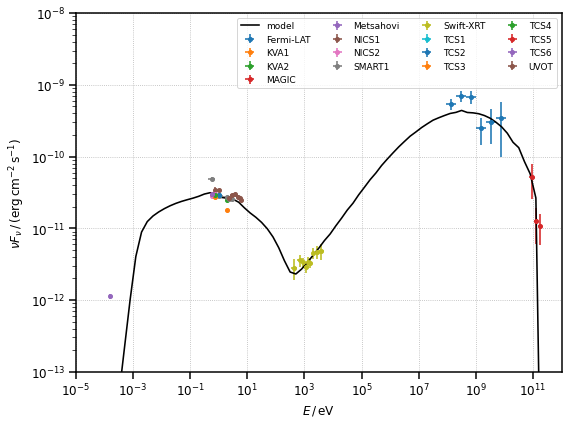

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

for dataset in datasets:
    dataset.data.plot(ax=ax, label=dataset.name)

ec_model.plot(
    ax=ax,
    energy_bounds=[1e-6, 1e14] * u.eV,
    energy_power=2,
    label="model",
    color="k",
    lw=1.6,
)

ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.set_xlim([1e-5, 1e12])
ax.set_ylim([1e-13, 1e-8])
ax.legend(ncol=4, fontsize=9)

plt.show()